<a href="https://colab.research.google.com/github/BeamlakTamirat/DS/blob/main/GradientBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path  = kagglehub.dataset_download('elikplim/car-evaluation-data-set')

100%|██████████| 4.66k/4.66k [00:00<00:00, 5.10MB/s]

Extracting files...


In [ ]:
df = pd.read_csv(path + '/car_evaluation.csv', header=None)

In [ ]:
df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [ ]:
df.shape

(1728, 7)

In [ ]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.columns = col_names
col_names

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [ ]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
for col in col_names:
    print(df[col].value_counts())

buying
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
maint
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64
persons
2       576
4       576
more    576
Name: count, dtype: int64
lug_boot
small    576
med      576
big      576
Name: count, dtype: int64
safety
low     576
med     576
high    576
Name: count, dtype: int64
class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


In [ ]:
df['class'].value_counts()

,count
class,
unacc,1210
acc,384
good,69
vgood,65


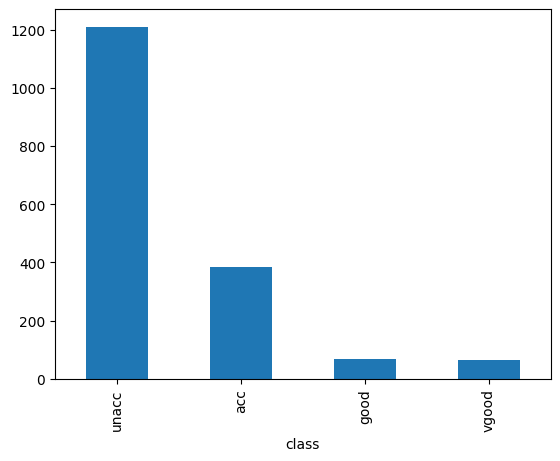

In [ ]:
df['class'].value_counts().plot(kind='bar');

## Split

In [ ]:
X = df.drop(columns=['class'], axis=1)
y = df['class']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Encode

In [ ]:
import category_encoders as ce
# encode categorical variables with ordinal encoding
encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

## OverSampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler()
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (3900, 6)


,buying,maint,doors,persons,lug_boot,safety
0,1,1,1,1,1,1
1,2,1,2,2,2,2
2,3,2,1,3,1,1
3,4,3,3,3,3,2
4,4,3,2,3,3,3


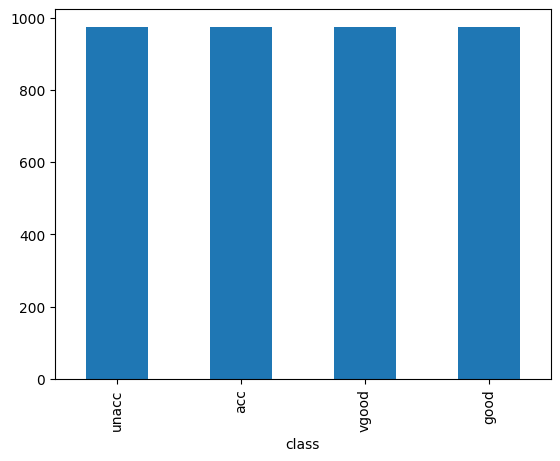

In [ ]:
y_train_over.value_counts().plot(kind='bar');

In [ ]:
X_train_over.isna().sum(),

(buying      0
 maint       0
 doors       0
 persons     0
 lug_boot    0
 safety      0
 dtype: int64,)

In [ ]:
y_train_over.isna().sum()

np.int64(0)

## Hyper Paramater Tuning and Cross Validation

In [ ]:
param = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

In [ ]:
random_search.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# Evaluate
from sklearn.metrics import accuracy_score
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print("Test Accuracy:", accuracy)

Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 5, 'max_depth': 4, 'learning_rate': 0.1}
Test Accuracy: 0.9913294797687862
